In [1]:
import tensorflow as tf
import os
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

if not os.path.isdir('models'):
    os.mkdir('models')
    
print('Tensorflow version:', tf.__version__)
print('Is using GPU?', tf.test.is_gpu_available())

Tensorflow version: 2.0.0
Is using GPU? False


__Pre-process Data:__

For Preporcessing the Data we using CIFAR-10 dataset. It has 10 classes but to speed up the process we only using first three classes, 0, 1 and 2. 

(CIFAR-10 dataset contains 60,000 examples in training set and 10,000 in test set, having 32x32 images each in 10 different classes. CIFAR-10 is an established computer-vision dataset used for object recognition.)

- Below is a function which return all the examples and label pairs for the first classes with class Id 0, 1 and 2.
- Function will x and y as input, as training set and test set repectively. 
- It will return indices using where() method, where label y is 0, 1 or 2 repectively.
- then we concatenate these three indices along the first axis(or axis = 0).
- we only select examples and labels which corresponds to those indices.
- then we shuffle the indices we get in the above step. Using random fucntion with three aruguments, first is the list from 0 to n-1(n is the no. of examples we selected after concatenation), second is the size of the training set(or shape of x(.shape[0]), i.e., no. of choice to choose from), and last one is for no repeatiton of same examples so we set it to False.
- and above whole step will ensures that selected indices are completely random and unique.
- then again we select examples and labels which corresponds to those indices but this from those shuffled and unique indices.
- lastly we convert the labels into one hot encoded vectors and return the output.

In [2]:
def get_three_classes(x, y):
    indices_0, _ = np.where(y == 0.)
    indices_1, _ = np.where(y == 1.)
    indices_2, _ = np.where(y == 2.)
    
    indices = np.concatenate([indices_0, indices_1, indices_2], axis=0)
    
    x = x[indices]
    y = y[indices]
    
    count = x.shape[0]
    indices = np.random.choice(range(count), count, replace=False)
    
    x = x[indices]
    y = y[indices]
    
    y = tf.keras.utils.to_categorical(y)
    
    return x, y

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
x_train, y_train = get_three_classes(x_train, y_train)
x_test, y_test = get_three_classes(x_test, y_test)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(15000, 32, 32, 3) (15000, 3)
(3000, 32, 32, 3) (3000, 3)


15000 32x32 images having 3 channels(RGB) in train set and 15000 labels associated to those images in 3 different classes as one hot encoded vector.

__Visualize Examples:__

- defining class name for 3 classes.
- a function with input, example, labels, and a prediction.
- selecting randon examples, similar to the above example. The arguments in choice() method first is choices(or shape of train set), second is no. of examples we want and 3rd is to not allowing repeatition so that all the values return are unique.
- similar to before selecting examples and labels along with that this we selecting prediction as well of the the selected indices.
- then plotting a figure of size 10x5 for plotting examples.

(argmax: Argmax is an operation that finds the argument that gives the maximum value from a target function.)

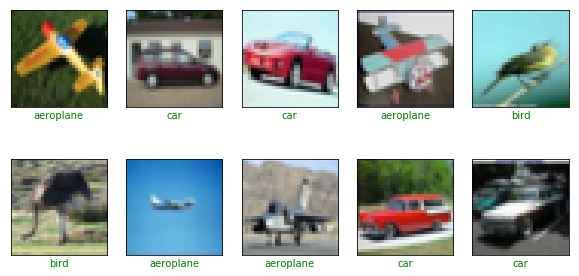

In [4]:
class_name = ['aeroplane', 'car', 'bird']

def show_random_examples(x, y, pred):
    indices = np.random.choice(range(x.shape[0]), 10, replace=False)
    
    x = x[indices]
    y = y[indices]
    pred = pred[indices]
    
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2, 5, 1 + i)
        plt.imshow(x[i])
        plt.xticks([])
        plt.yticks([])
        col = 'green' if np.argmax(y[i]) == np.argmax(pred[i]) else 'red'
        plt.xlabel(class_name[np.argmax(pred[i])], color = col)
    plt.show()

show_random_examples(x_train, y_train, y_train)

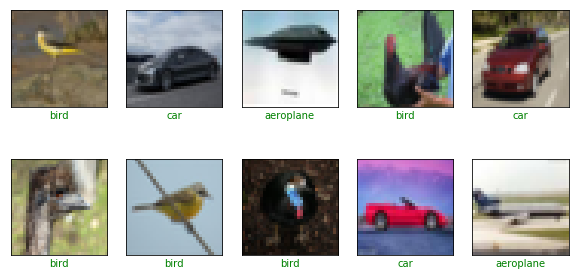

In [5]:
show_random_examples(x_test, y_test, y_test)

__Creating Model:__

Using CNNs to bulid this model and hnce importing necessary files from tensorflow.
- Conv2D: Keras Conv2D is a 2D Convolution Layer, this layer creates a convolution kernel that is wind with layers input which helps produce a tensor of outputs.
- MaxPooling2D: Max pooling is a sample-based <i>discretization^</i> process. The objective is to down-sample an input representation, reducing its dimensionality and allowing for assumptions to be made about features contained in the sub-regions binned.
- Batch normalization: Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks. Primarily used to ensure that there's not a lot of co-variance shift at output of preceding layer.
- Dropout: Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data. The term "dropout" refers to dropping out units (both hidden and visible) in a neural network.
- Flatten: A flatten operation on a tensor reshapes the tensor to have the shape that is equal to the number of elements contained in tensor non including the batch dimension.
- Input: Input() is used to instantiate a Keras tensor.
- Dense: Dense layer is the regular deeply connected neural network layer. 

- kernel size: The kernel size here refers to the widthxheight of the filter mask.

^data discretization: Data discretization is defined as a process of converting continuous data attribute values into a finite set of intervals with minimal loss of information.

In [6]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense

def create_model():
    def add_conv_block(model, num_filters):
        model.add(Conv2D(num_filters, 3, activation='relu', padding='same'))
        model.add(BatchNormalization())
        model.add(Conv2D(num_filters, 3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
        model.add(Dropout(0.5))
        return model
    
    model = tf.keras.models.Sequential()
    model.add(Input(shape=(32, 32, 3)))
    
    model = add_conv_block(model, 32)
    model = add_conv_block(model, 64)
    model = add_conv_block(model, 128)
    
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']
    )
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 15, 64)        2

 __Training the model:__
 
- for that using fit() method, inside it we normalize x_train and y_train by dividing the pixel value of each image by 255(because pixels are in range of 0 to 255). And we convert the value of each example in between 0 and 1.
- Callback: Callbacks provide a way to execute code and interact with the training model process automatically.
- we can use early stopping callback, if we want to monitor some parameters like validation accuracy and make sure that if our training is not going in the right direction then we don't waste a lot of time continuing the training process. And we may need to change some hyperparameters before restart the training process again. 
- we setting patience = 3, meaning we will check after 3 epochs our training set and decide whether we want to continue or need to make some changes.
- then we save our best models only, after 3 epochs by the validation accuracy as its name, so that we can identify which model worked the best.



In [13]:
h = model.fit(
    x_train/255., y_train,
    validation_data=(x_test/255., y_test),
    epochs=10, batch_size=64,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3),
        tf.keras.callbacks.ModelCheckpoint('models/model_{val_accuracy:.3f}.h5',
                                           save_best_only=True, save_weights_only=False,
                                           monitor='val_accuracy')
    ]
)

Train on 15000 samples, validate on 3000 samples
Epoch 1/10
15000/15000 [==============================] - 202s 13ms/sample - loss: 0.3567 - accuracy: 0.8583 - val_loss: 0.3297 - val_accuracy: 0.8683
Epoch 2/10
15000/15000 [==============================] - 219s 15ms/sample - loss: 0.3265 - accuracy: 0.8720 - val_loss: 0.6115 - val_accuracy: 0.8083
Epoch 3/10
15000/15000 [==============================] - 205s 14ms/sample - loss: 0.3093 - accuracy: 0.8823 - val_loss: 0.6391 - val_accuracy: 0.7823
Epoch 4/10
15000/15000 [==============================] - 204s 14ms/sample - loss: 0.2832 - accuracy: 0.8895 - val_loss: 0.4788 - val_accuracy: 0.8140


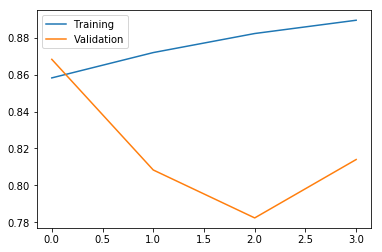

In [14]:
accs = h.history['accuracy']
val_accs = h.history['val_accuracy']

plt.plot(range(len(accs)), accs, label='Training')
plt.plot(range(len(accs)), val_accs, label='Validation')
plt.legend()
plt.show()

In [16]:
model = tf.keras.models.load_model('models/model_0.868.h5')

In [17]:
preds = model.predict(x_test/255.)

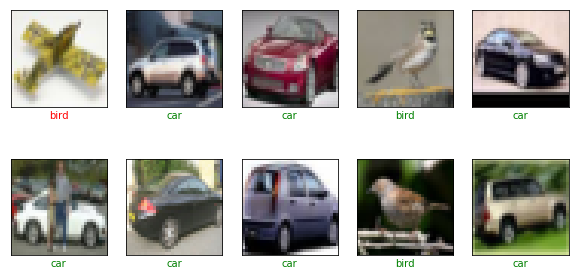

In [21]:
show_random_examples(x_test, y_test, preds)